In [18]:
%matplotlib inline

In [19]:
import os, sys
import re
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from uncertainties import ufloat

In [20]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.width"] = 1.0
plt.rcParams["ytick.major.width"] = 1.0
plt.rcParams["font.size"] = 8
plt.rcParams["axes.linewidth"] = 1.5

In [21]:
formatter = mticker.ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
formatter.set_useOffset(False)

In [22]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [23]:
import ipynb_path

root_dir = os.path.dirname(ipynb_path.get())
os.chdir(root_dir)

In [24]:
Ha_to_meV = 27.2114 * 1000

In [25]:
# def read
def read_lrdmc_energy(file):
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if re.match(".*Total.*Energy:*", line):
                e_mean = float(line.split()[4])
                e_std = float(line.split()[6])
                return ufloat(e_mean, e_std)
        return ufloat(np.nan, np.nan)

In [26]:
# find the last LRDMC file
def find_max_out_lrdmc_cont(folder_path):
    pattern = re.compile(r"out_lrdmc_cont(\d+)\.o")
    max_x = -1
    max_file = None

    for file_path in glob.glob(os.path.join(folder_path, "out_lrdmc_cont*.o")):
        match = pattern.search(os.path.basename(file_path))
        if match:
            x_value = int(match.group(1))
            if x_value > max_x:
                max_x = x_value
                max_file = file_path

    return max_file

In [27]:
# define functions for fitting.
def fit_E_LRDMC(x, y, y_err, xs, monte_calro_loop=100, order=2):
    val_pd = pd.DataFrame(index=[], columns=x)
    val_pd_plot = pd.DataFrame(index=[], columns=xs)
    y_zero_list = []
    sigma_list = []
    for v in y:
        sigma_list.append(np.random.randn(monte_calro_loop))

    for m in range(monte_calro_loop):
        y_gen = []
        for i, v in enumerate(y):
            y_gen.append(y[i] + y_err[i] * sigma_list[i][m])

        # polyfit
        w = np.polyfit(x, y_gen, order)
        ys = np.polyval(w, x)
        ys_plot = np.polyval(w, xs)
        c = np.poly1d(w).deriv(1)
        ys_deriv = c(x)
        ys_deriv_plot = c(xs)

        # record
        record = pd.Series(ys, index=val_pd.columns)
        val_pd = val_pd._append(record, ignore_index=True)

        # record for plot
        record = pd.Series(ys_plot, index=val_pd_plot.columns)
        val_pd_plot = val_pd_plot._append(record, ignore_index=True)

        # extrapolated energy
        c = np.poly1d(w)
        y_zero_list.append(c(0.0))

    y_zero_list = np.array(y_zero_list)
    y_mean = np.array(list(val_pd.mean()))
    y_std = np.array(list(val_pd.std()))
    y_mean_plot = np.array(list(val_pd_plot.mean()))
    y_std_plot = np.array(list(val_pd_plot.std()))

    return y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot

In [29]:
# DLTM
alat_list = [0.1, 0.15, 0.20, 0.25, 0.3]

# methane
methane_lrdmc_dirs = [os.path.join(root_dir, "01m_ccecp_ccpvtz", "lrdmc_dlatm", f"alat_{alat:.2f}") for alat in alat_list]
methane_lrdmc_files = [find_max_out_lrdmc_cont(methane_lrdmc_dir) for methane_lrdmc_dir in methane_lrdmc_dirs]
methane_lrdmc_energy = [read_lrdmc_energy(methane_lrdmc_file) for methane_lrdmc_file in methane_lrdmc_files]

# water
water_lrdmc_dirs = [os.path.join(root_dir, "02w_ccecp_ccpvtz", "lrdmc_dlatm", f"alat_{alat:.2f}") for alat in alat_list]
water_lrdmc_files = [find_max_out_lrdmc_cont(water_lrdmc_dir) for water_lrdmc_dir in water_lrdmc_dirs]
water_lrdmc_energy = [read_lrdmc_energy(water_lrdmc_file) for water_lrdmc_file in water_lrdmc_files]

# water-methane
water_methane_lrdmc_dirs = [os.path.join(root_dir, '03m_w_ccecp_ccpvtz', 'lrdmc_dlatm', f'alat_{alat:.2f}') for alat in alat_list]
water_methane_lrdmc_files = [find_max_out_lrdmc_cont(water_methane_lrdmc_dir) for water_methane_lrdmc_dir in water_methane_lrdmc_dirs]
water_methane_lrdmc_energy = [read_lrdmc_energy(water_methane_lrdmc_file) for water_methane_lrdmc_file in water_methane_lrdmc_files]

# binding energy
binding_energy = [(mw - m - w) * Ha_to_meV for m,w,mw in zip(methane_lrdmc_energy, water_lrdmc_energy, water_methane_lrdmc_energy)]

# methane(tau)
methane_lrdmc_tau_dirs = [
    os.path.join(root_dir, "01m_ccecp_ccpvtz", "lrdmc_dlatm_tau", f"alat_{alat:.2f}") for alat in alat_list
]
methane_lrdmc_tau_files = [find_max_out_lrdmc_cont(methane_lrdmc_tau_dir) for methane_lrdmc_tau_dir in methane_lrdmc_tau_dirs]
methane_lrdmc_tau_energy = [read_lrdmc_energy(methane_lrdmc_tau_file) for methane_lrdmc_tau_file in methane_lrdmc_tau_files]

# water(tau)
water_lrdmc_tau_dirs = [os.path.join(root_dir, "02w_ccecp_ccpvtz", "lrdmc_dlatm_tau", f"alat_{alat:.2f}") for alat in alat_list]
water_lrdmc_tau_files = [find_max_out_lrdmc_cont(water_lrdmc_tau_dir) for water_lrdmc_tau_dir in water_lrdmc_tau_dirs]
water_lrdmc_tau_energy = [read_lrdmc_energy(water_lrdmc_tau_file) for water_lrdmc_tau_file in water_lrdmc_tau_files]

In [43]:
# DLTM
methane_dmc_energy_ref = {
    "turborvb": {
        0.05: ufloat(-8.078634348, 1.53e-05),
        0.10: ufloat(-8.078754283, 1.54e-05),
        0.15: ufloat(-8.078894674, 1.54e-05),
        0.20: ufloat(-8.079092898, 1.56e-05),
        0.25: ufloat(-8.079288205, 1.53e-05),
        0.30: ufloat(-8.079599295, 1.51e-05),
    },
    "qmcpack": {
        0.08: ufloat(-8.080768877092906, 2.702815549577107e-05),
        0.04: ufloat(-8.07972495832564, 1.8914154623871482e-05),
        0.02: ufloat(-8.079213989222325, 2.0974144206585715e-05),
        0.01: ufloat(-8.078899791509691, 2.2906267866775823e-05),
        0.005: ufloat(-8.078725807033866, 2.0020278227736306e-05),
        0.0025: ufloat(-8.078635816623551, 2.14341417734811e-05),
    },
    "casino": {
        0.64: ufloat(-8.093779514343998, 1.1165414845150535e-05),
        0.32: ufloat(-8.083517956014536, 1.2240868573175693e-05),
        0.16: ufloat(-8.079344709549877, 1.4843301799731997e-05),
        0.08: ufloat(-8.078025044940263, 1.6291093613138255e-05),
        0.04: ufloat(-8.077901161115454, 1.506202234024889e-05),
        0.02: ufloat(-8.078105857593883, 1.5988963155089308e-05),
        0.01: ufloat(-8.078250643817793, 1.6430960413721432e-05),
        0.005: ufloat(-8.078390651284371, 1.4967553583207512e-05),
        0.0025: ufloat(-8.07847659061949, 1.6353562423645458e-05),
    },
}

water_dmc_energy_ref = {
    "turborvb": {
        0.05: ufloat(-17.23486697, 1.40e-05),
        0.10: ufloat(-17.23507474, 1.35e-05),
        0.15: ufloat(-17.23539581, 1.37e-05),
        0.20: ufloat(-17.23572876, 1.39e-05),
        0.25: ufloat(-17.23610915, 1.39e-05),
        0.30: ufloat(-17.23648320, 1.32e-05),
    },
    "qmcpack": {
        0.08: ufloat(-17.2434189841611, 2.6396278427460472e-05),
        0.04: ufloat(-17.239453109288, 2.5813340177210553e-05),
        0.02: ufloat(-17.23742344452136, 2.3988035574147145e-05),
        0.01: ufloat(-17.236218947004076, 2.5050384331373678e-05),
        0.005: ufloat(-17.235511971448112, 2.452840158140857e-05),
        0.0025: ufloat(-17.23520218477908, 2.1321806493765432e-05),
    },
    "casino": {
        0.64: ufloat(-17.283771390853477, 2.0027378005577987e-05),
        0.32: ufloat(-17.25257899170143, 2.1830682505879327e-05),
        0.16: ufloat(-17.239870516889944, 2.1016657777142013e-05),
        0.08: ufloat(-17.234759632969777, 2.635196895746475e-05),
        0.04: ufloat(-17.23340066103765, 2.292114805130096e-05),
        0.02: ufloat(-17.23350562958967, 2.101347339269575e-05),
        0.01: ufloat(-17.23394956292525, 2.2332781981705757e-05),
        0.005: ufloat(-17.23427019536041, 2.129980942494666e-05),
        0.0025: ufloat(-17.23447016009584, 1.9493613840996026e-05),
    },
}

water_methane_dmc_energy_ref = {
    "turborvb": {
        0.05: ufloat(-25.31454658, 2.07E-05),
        0.10: ufloat(-25.31488331, 1.09E-05),
        0.15: ufloat(-25.31534936, 1.07E-05),
        0.20: ufloat(-25.31591077, 1.07E-05),
        0.25: ufloat(-25.31652186, 1.10E-05),
        0.30: ufloat(-25.31718788, 1.06E-05)
    },
    "qmcpack": {
        0.08: ufloat(-25.32672198105947, 4.043805860882674e-05),
        0.04: ufloat(-25.321039280851423, 3.6657521682864494e-05),
        0.02: ufloat(-25.318028658346265, 3.6502026942973945e-05),
        0.01: ufloat(-25.316438746752326, 3.4028094465875924e-05),
        0.005: ufloat(-25.31541558440216, 3.460211104941045e-05),
        0.0025: ufloat(-25.314929434613028, 3.558302712943598e-05)
    },
    "casino": {
        0.64: ufloat(-25.383267207294494, 2.8798192334045298e-05),
        0.32: ufloat(-25.338124112513977, 2.9747436786168356e-05),
        0.16: ufloat(-25.3204123013807, 2.941925509261321e-05),
        0.08: ufloat(-25.31370170516422, 2.7781448346466094e-05),
        0.04: ufloat(-25.31216322000225, 3.364126350402864e-05),
        0.02: ufloat(-25.312493382691937, 2.89819456892005e-05),
        0.01: ufloat(-25.313059204783798, 3.284249786762957e-05),
        0.005: ufloat(-25.313576014015133, 3.1807081996101304e-05),
        0.0025: ufloat(-25.31395044794631, 2.6787472964598265e-05)
    },
}

binding_energy_ref={}
package_list = ['turborvb', 'casino', 'qmcpack']
for package in package_list:
    binding_energy_ref[package]={tau: (water_methane_dmc_energy_ref[package][tau] - water_dmc_energy_ref[package][tau] - methane_dmc_energy_ref[package][tau])  * Ha_to_meV for tau in water_methane_dmc_energy_ref[package].keys()}

-8.07872+/-0.00015
-8.07859+/-0.00017
-17.23459+/-0.00016
-17.23476+/-0.00016
Binding energy of Methane-Water dimer = -25.87(71) meV


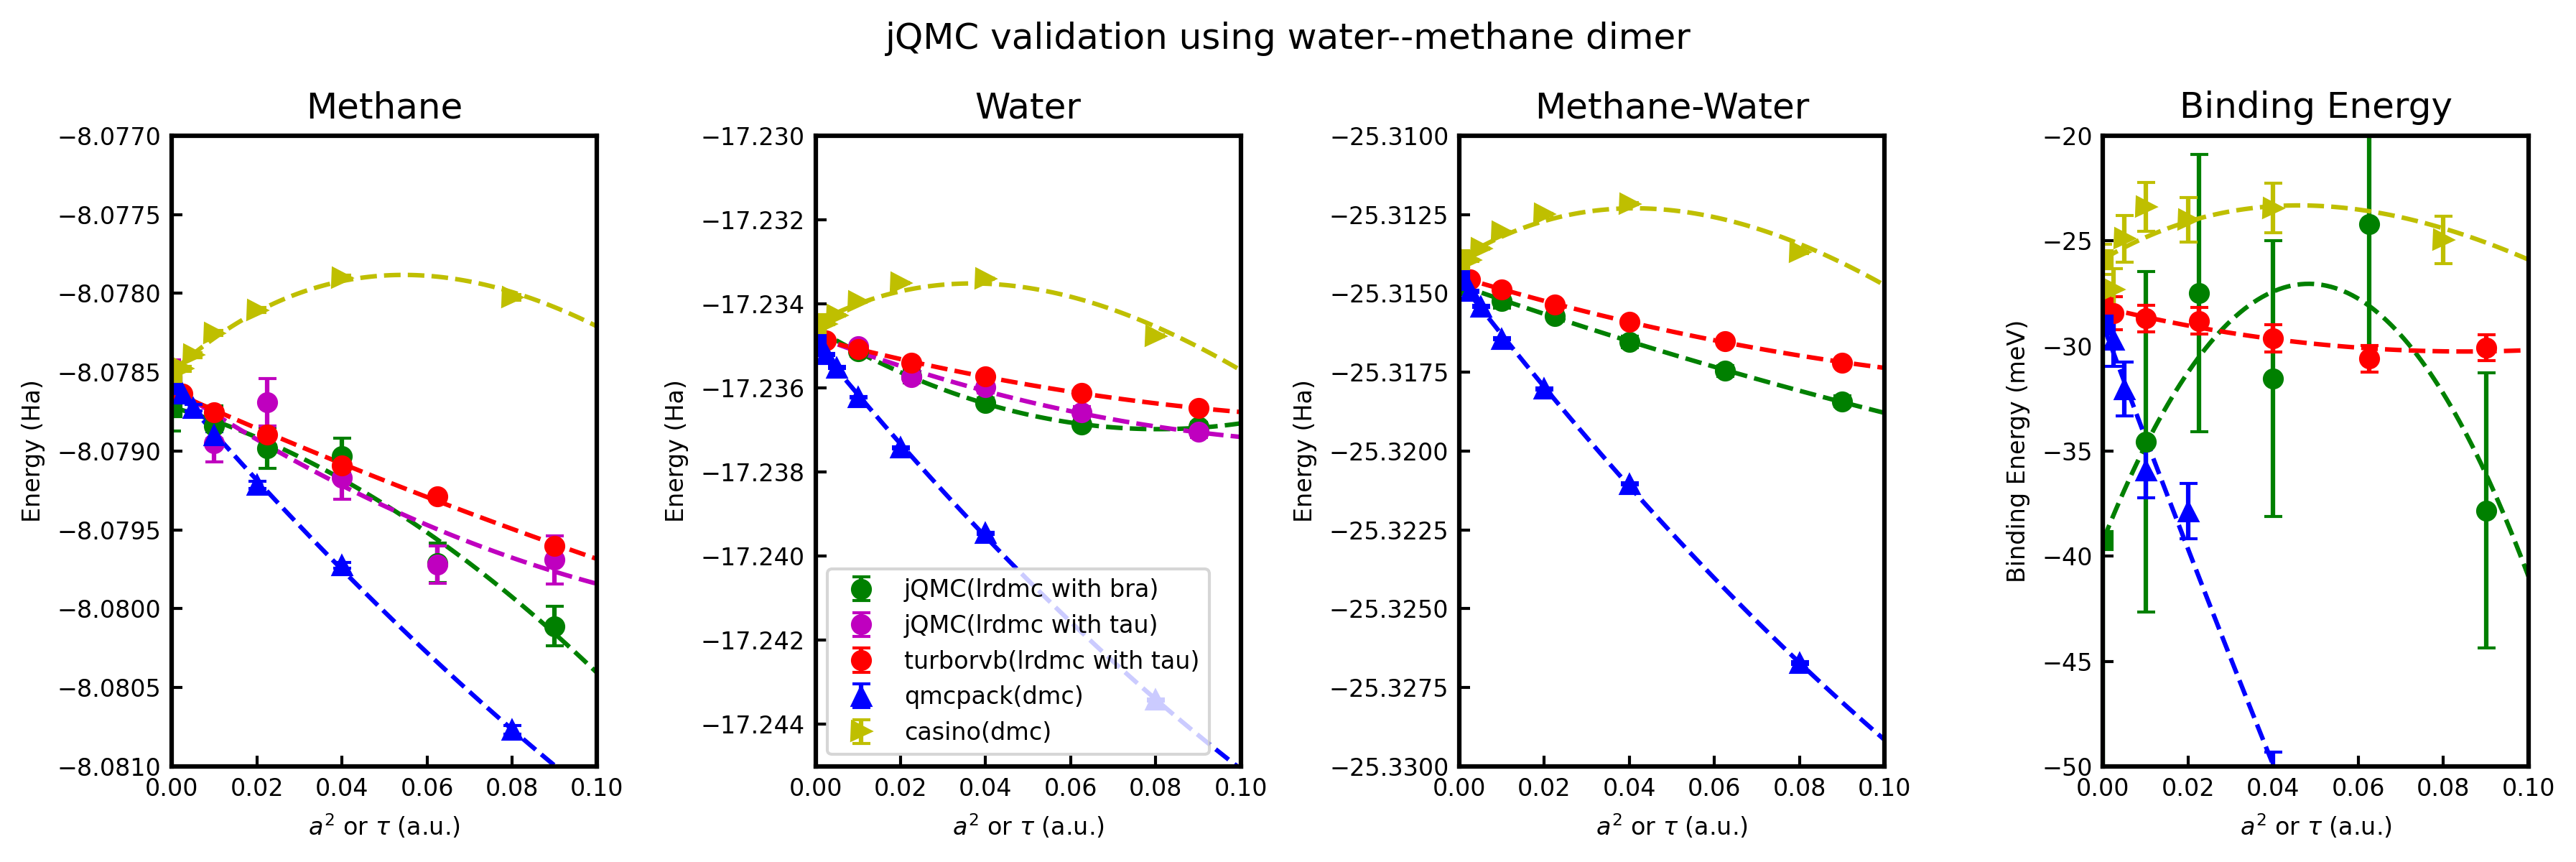

In [47]:
# plot Graph
fig = plt.figure(figsize=(12, 4), facecolor="white", dpi=300, tight_layout=True)
fig.suptitle(rf"jQMC validation using water--methane dimer", fontsize=12)
x_min = 0.0
x_max = 0.1
xs = np.linspace(x_min, x_max, 100)

# methane
y_min = -8.081
y_max = -8.077
ax1 = fig.add_subplot(1, 4, 1)
ax1.set_title("Methane", fontsize=12)
ax1.set_xlabel(r"$a^2$ or $\tau$ (a.u.)")
ax1.set_ylabel("Energy (Ha)")
ax1.set_xlim([x_min, x_max])
ax1.set_ylim([y_min, y_max])
ax1.yaxis.set_major_formatter(formatter)

## jQMC
x = np.array(alat_list) ** 2
y = np.array([e.n for e in methane_lrdmc_energy])
yerr = np.array([e.s for e in methane_lrdmc_energy])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax1.errorbar(x, y, yerr=yerr, color="g", marker="o", ls="", alpha=1.0, capsize=3, label="jQMC")
ax1.plot(xs, y_mean_plot, color="g", marker="", ls="--")
ax1.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="g", marker="s", alpha=1.0, capsize=3)
print(E_ext)

## jQMC (tau)
x = np.array(alat_list) ** 2
y = np.array([e.n for e in methane_lrdmc_tau_energy])
yerr = np.array([e.s for e in methane_lrdmc_tau_energy])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax1.errorbar(x, y, yerr=yerr, color="m", marker="o", ls="", alpha=1.0, capsize=3, label="jQMC(tau)")
ax1.plot(xs, y_mean_plot, color="m", marker="", ls="--")
ax1.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="m", marker="s", alpha=1.0, capsize=3)
print(E_ext)

## turborvb
alat_list_ref = list(methane_dmc_energy_ref["turborvb"].keys())
energy_list_ref = list(methane_dmc_energy_ref["turborvb"].values())
x = np.array([float(a) for a in alat_list_ref]) ** 2
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax1.errorbar(x, y, yerr=yerr, color="r", marker="o", ls="", alpha=1.0, capsize=3, label="turborvb(tau)")
ax1.plot(xs, y_mean_plot, color="r", marker="", ls="--")
ax1.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="r", marker="s", alpha=1.0, capsize=3)

## qmcpack
tau_list_ref = list(methane_dmc_energy_ref["qmcpack"].keys())
energy_list_ref = list(methane_dmc_energy_ref["qmcpack"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax1.errorbar(x, y, yerr=yerr, color="b", marker="^", ls="", alpha=1.0, capsize=3, label="qmcpack")
ax1.plot(xs, y_mean_plot, color="b", marker="", ls="--")
ax1.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="b", marker="s", alpha=1.0, capsize=3)
ax1.yaxis.set_major_formatter(formatter)

## casino
tau_list_ref = list(methane_dmc_energy_ref["casino"].keys())
energy_list_ref = list(methane_dmc_energy_ref["casino"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=4)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax1.errorbar(x, y, yerr=yerr, color="y", marker=">", ls="", alpha=1.0, capsize=3, label="casino")
ax1.plot(xs, y_mean_plot, color="y", marker="", ls="--")
ax1.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="y", marker="s", alpha=1.0, capsize=3)
ax1.yaxis.set_major_formatter(formatter)

# water
y_min = -17.245
y_max = -17.230
ax2 = fig.add_subplot(1, 4, 2)
ax2.set_title("Water", fontsize=12)
ax2.set_xlabel(r"$a^2$ or $\tau$ (a.u.)")
ax2.set_ylabel("Energy (Ha)")
ax2.set_xlim([x_min, x_max])
ax2.set_ylim([y_min, y_max])
ax2.yaxis.set_major_formatter(formatter)

## jQMC
x = np.array(alat_list) ** 2
y = np.array([e.n for e in water_lrdmc_energy])
yerr = np.array([e.s for e in water_lrdmc_energy])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax2.errorbar(x, y, yerr=yerr, color="g", marker="o", ls="", alpha=1.0, capsize=3, label="jQMC(lrdmc with bra)")
ax2.plot(xs, y_mean_plot, color="g", marker="", ls="--")
ax2.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="g", marker="s", alpha=1.0, capsize=3)
print(E_ext)

## jQMC(tau)
x = np.array(alat_list) ** 2
y = np.array([e.n for e in water_lrdmc_tau_energy])
yerr = np.array([e.s for e in water_lrdmc_tau_energy])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax2.errorbar(x, y, yerr=yerr, color="m", marker="o", ls="", alpha=1.0, capsize=3, label="jQMC(lrdmc with tau)")
ax2.plot(xs, y_mean_plot, color="m", marker="", ls="--")
ax2.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="m", marker="s", alpha=1.0, capsize=3)
print(E_ext)

## turborvb
alat_list_ref = list(water_dmc_energy_ref["turborvb"].keys())
energy_list_ref = list(water_dmc_energy_ref["turborvb"].values())
x = np.array([float(a) for a in alat_list_ref]) ** 2
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax2.errorbar(x, y, yerr=yerr, color="r", marker="o", ls="", alpha=1.0, capsize=3, label="turborvb(lrdmc with tau)")
ax2.plot(xs, y_mean_plot, color="r", marker="", ls="--")
ax2.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="r", marker="s", alpha=1.0, capsize=3)

## qmcpack
tau_list_ref = list(water_dmc_energy_ref["qmcpack"].keys())
energy_list_ref = list(water_dmc_energy_ref["qmcpack"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax2.errorbar(x, y, yerr=yerr, color="b", marker="^", ls="", alpha=1.0, capsize=3, label="qmcpack(dmc)")
ax2.plot(xs, y_mean_plot, color="b", marker="", ls="--")
ax2.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="b", marker="s", alpha=1.0, capsize=3)

## casino
tau_list_ref = list(water_dmc_energy_ref["casino"].keys())
energy_list_ref = list(water_dmc_energy_ref["casino"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=4)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax2.errorbar(x, y, yerr=yerr, color="y", marker=">", ls="", alpha=1.0, capsize=3, label="casino(dmc)")
ax2.plot(xs, y_mean_plot, color="y", marker="", ls="--")
ax2.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="y", marker="s", alpha=1.0, capsize=3)

plt.legend()

# water--methane
y_min = -25.330
y_max = -25.310

ax3 = fig.add_subplot(1, 4, 3)
ax3.set_title("Methane-Water", fontsize=12)
ax3.set_xlabel(r"$a^2$ or $\tau$ (a.u.)")
ax3.set_ylabel("Energy (Ha)")
ax3.set_xlim([x_min, x_max])
ax3.set_ylim([y_min, y_max])
ax3.yaxis.set_major_formatter(formatter)

## jQMC(bra)
x=np.array(alat_list)**2
xs=np.linspace(x_min,x_max,100)
y=np.array([e.n for e in water_methane_lrdmc_energy])
yerr=np.array([e.s for e in water_methane_lrdmc_energy])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax3.errorbar(x, y, yerr=yerr, color="g", marker="o", ls='', alpha=1.0, capsize=3)
ax3.plot(xs, y_mean_plot, color="g", marker="", ls='--')
ax3.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="g", marker="s", label='Extrapolated', alpha=1.0, capsize=3)
ax3.yaxis.set_major_formatter(formatter)

## turborvb
alat_list_ref = list(water_methane_dmc_energy_ref["turborvb"].keys())
energy_list_ref = list(water_methane_dmc_energy_ref["turborvb"].values())
x = np.array([float(a) for a in alat_list_ref]) ** 2
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax3.errorbar(x, y, yerr=yerr, color="r", marker="o", ls="", alpha=1.0, capsize=3, label="turborvb(tau)")
ax3.plot(xs, y_mean_plot, color="r", marker="", ls="--")
ax3.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="r", marker="s", alpha=1.0, capsize=3)

## qmcpack
tau_list_ref = list(water_methane_dmc_energy_ref["qmcpack"].keys())
energy_list_ref = list(water_methane_dmc_energy_ref["qmcpack"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax3.errorbar(x, y, yerr=yerr, color="b", marker="^", ls="", alpha=1.0, capsize=3, label="qmcpack(dmc)")
ax3.plot(xs, y_mean_plot, color="b", marker="", ls="--")
ax3.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="b", marker="s", alpha=1.0, capsize=3)

## casino
tau_list_ref = list(water_methane_dmc_energy_ref["casino"].keys())
energy_list_ref = list(water_methane_dmc_energy_ref["casino"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=4)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax3.errorbar(x, y, yerr=yerr, color="y", marker=">", ls="", alpha=1.0, capsize=3, label="casino(dmc)")
ax3.plot(xs, y_mean_plot, color="y", marker="", ls="--")
ax3.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="y", marker="s", alpha=1.0, capsize=3)

# binding energy
y_min = -50.0
y_max = -20.0
ax4 = fig.add_subplot(1, 4, 4)
ax4.set_title("Binding Energy", fontsize=12)
ax4.set_xlabel(r"$a^2$ or $\tau$ (a.u.)")
ax4.set_ylabel("Binding Energy (meV)")
ax4.set_xlim([x_min, x_max])
ax4.set_ylim([y_min, y_max])
ax4.yaxis.set_major_formatter(formatter)

## jQMC
x=np.array(alat_list)**2
xs=np.linspace(x_min,x_max,100)
y=np.array([e.n for e in binding_energy])
yerr=np.array([e.s for e in binding_energy])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax4.errorbar(x, y, yerr=yerr, color="g", marker="o", ls='', alpha=1.0, capsize=3)
ax4.plot(xs, y_mean_plot, color="g", marker="", ls='--')
ax4.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="g", marker="s", label='Extrapolated', alpha=1.0, capsize=3)

## turborvb
alat_list_ref = list(binding_energy_ref["turborvb"].keys())
energy_list_ref = list(binding_energy_ref["turborvb"].values())
x = np.array([float(a) for a in alat_list_ref]) ** 2
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax4.errorbar(x, y, yerr=yerr, color="r", marker="o", ls="", alpha=1.0, capsize=3, label="turborvb(tau)")
ax4.plot(xs, y_mean_plot, color="r", marker="", ls="--")
ax4.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="r", marker="s", alpha=1.0, capsize=3)

## qmcpack
tau_list_ref = list(binding_energy_ref["qmcpack"].keys())
energy_list_ref = list(binding_energy_ref["qmcpack"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax4.errorbar(x, y, yerr=yerr, color="b", marker="^", ls="", alpha=1.0, capsize=3, label="qmcpack(dmc)")
ax4.plot(xs, y_mean_plot, color="b", marker="", ls="--")
ax4.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="b", marker="s", alpha=1.0, capsize=3)

## casino
tau_list_ref = list(binding_energy_ref["casino"].keys())
energy_list_ref = list(binding_energy_ref["casino"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=4)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax4.errorbar(x, y, yerr=yerr, color="y", marker=">", ls="", alpha=1.0, capsize=3, label="casino(dmc)")
ax4.plot(xs, y_mean_plot, color="y", marker="", ls="--")
ax4.errorbar(0.0, E_ext.n, yerr=E_ext.s, color="y", marker="s", alpha=1.0, capsize=3)

print(f"Binding energy of Methane-Water dimer = {E_ext:.2uS} meV")

plt.savefig("jqmc_validation_water_methane.jpg")
plt.show()